# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000L, 784L)
label shape: (70000L,)


In [3]:
mnist.data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

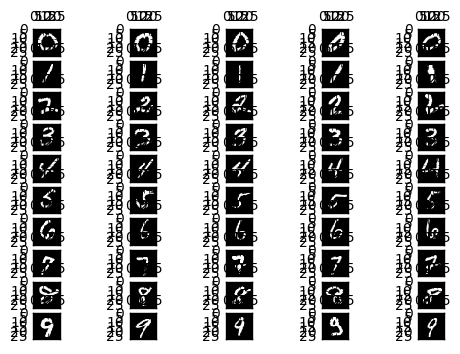

In [4]:
### STUDENT START ###
def P1(num_examples):
    fig, axes = plt.subplots(10, num_examples)
    for i in range(10):  #we have 10 digits we want to characterize
        digits = train_data[train_labels == i][:num_examples]  #want to show each example
        for j, digit in enumerate(digits):
            ax = axes[i][j]
            ax.matshow(digit.reshape(28, 28), cmap=plt.cm.gray, vmin=0.0, vmax=1.0)

### STUDENT END ###
P1(5)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [5]:
### STUDENT START ###
def P2(k_values):
    for k in k_values:
        
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(mini_train_data, mini_train_labels) #let's fit to the mini training data set
        preds = neigh.predict(dev_data)  #predict on the development set
    
        correct, total = 0, 0 #set the preliminary values of correct and total to 0
        #print preds
        for pred, label in zip(preds, dev_labels):
            if pred == label: correct += 1
            total += 1
        print 'K: %s   total: %3d  correct: %3d  accuracy: %3.2f' %(k, total, correct, 1.0*correct/total)
        
        print(classification_report(dev_labels,preds))

### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

K: 1   total: 1000  correct: 888  accuracy: 0.89
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

K: 3   total: 1000  correct: 878  accuracy: 0.88
             precision    recall  f1-score   support

        0.0       0.90      1.00      0.95        99
        1.0       0.81      1.00      0.89       105
        2.0       0.95      0.81      0.88       102
        3.0       0.69      0.84      0.75        

ANSWER: 9 is the most difficult digit for K-1, with low precision and f1-score.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [7]:
### STUDENT START ###
def P3(train_sizes,accuracies):
         
    for t in train_sizes:
            
        start = time.time() #start time
        neigh = KNeighborsClassifier(n_neighbors=1)
        neigh.fit(mini_train_data[:t], mini_train_labels[:t])  #this essentially takes the first t values of the mini training data set to use different training sizes
        preds = neigh.predict(dev_data)
        
    
        correct, total = 0, 0
        #print preds
        for pred, label in zip(preds, dev_labels):
            if pred == label: correct += 1
            total += 1
        print 'size: %s  total: %3d  correct: %3d  accuracy: %3.2f' %(t, total, correct, 1.0*correct/total)
        
        print(classification_report(dev_labels,preds))
        accuracies.append(float(1.0*correct/total))        
        end = time.time() #end time
    
        print 'size: %s  time: %s' %(t, (end-start))

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)
#print accuracies

size: 100  total: 1000  correct: 720  accuracy: 0.72
             precision    recall  f1-score   support

        0.0       0.86      0.95      0.90        99
        1.0       0.60      1.00      0.75       105
        2.0       0.90      0.60      0.72       102
        3.0       0.56      0.70      0.62        86
        4.0       0.92      0.47      0.62       104
        5.0       0.77      0.51      0.61        91
        6.0       0.87      0.86      0.86        98
        7.0       0.70      0.81      0.75       113
        8.0       0.92      0.47      0.62        96
        9.0       0.56      0.79      0.66       106

avg / total       0.77      0.72      0.71      1000

size: 100  time: 0.112999916077
size: 200  total: 1000  correct: 786  accuracy: 0.79
             precision    recall  f1-score   support

        0.0       0.91      0.96      0.94        99
        1.0       0.69      0.99      0.82       105
        2.0       0.95      0.62      0.75       102
        3.

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

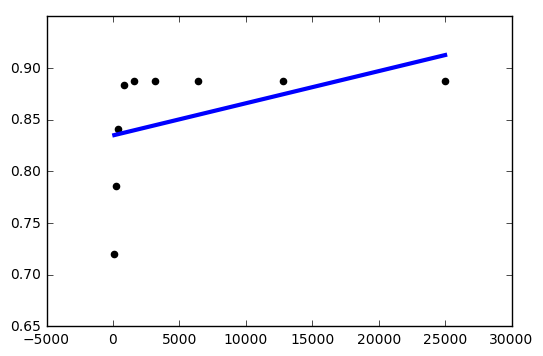

[ 1.02149154]


In [8]:
### STUDENT START ###
def P4():
    sizes = np.array(train_sizes).reshape(9,1) ##we need to reshape this so that we can use this in the fit function
    lm = LinearRegression().fit(sizes,accuracies)

    # Plot outputs
    plt.scatter(sizes, accuracies,  color='black')
    plt.plot(sizes, lm.predict(sizes), color='blue', linewidth=3)
    plt.show()
    
    print lm.predict(60000)
### STUDENT END ###

P4()

ANSWER: This predicts that with a training size of 60000, you get an accuracy of 1.02.  In this regression, you can see that there is an accuracy prediction above 1, which is impossible to get.  In order to make the prediction more reasonable, you can set upper and lower bounds to restrict the sizes so that anything with an accuracy amount below 0 or above 1 is not allowed or converted to the upper or lower bound numbers.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

In [9]:
### STUDENT START ###
def P5():
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(mini_train_data, mini_train_labels)
    preds = neigh.predict(dev_data)
    
    print confusion_matrix(dev_labels, preds)
        
### STUDENT END ###

P5()

[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]


(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

Blurred Training, Regular Dev accuracy: 0.50
Regular Training, Blurred Dev accuracy: 0.20
Blurred Training, Blurred Dev accuracy: 0.26


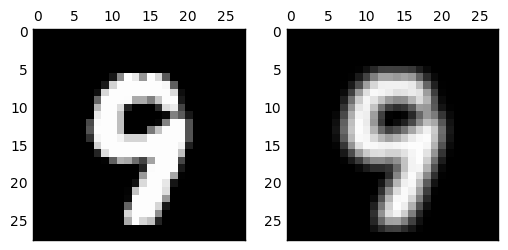

In [10]:
from scipy.signal import convolve2d
def P6():
    kernel = np.array([[0.5,0.5,0.5],\
                      [0.5,1,0.5],\
                      [0.5,0.5,0.5]])
    normalized_kernel = kernel / kernel.sum() # convolution kernel

    #check that my blur is working
    f,axes = plt.subplots(1,2)
    sample = mini_train_data[1].reshape((28,28))
    axes[0].matshow(sample,cmap=plt.cm.gray,vmin=0,vmax=1)# should show the regular image on the left
    axes[1].matshow(convolve2d(sample,normalized_kernel, mode='same'),cmap=plt.cm.gray,vmin=0,vmax=1) #and the blurred version on the right
    
    blurred_mini_train_data = convolve2d(mini_train_data, normalized_kernel, mode="same")
    blurred_dev_data = convolve2d(dev_data,normalized_kernel,mode='same')# we will need the blurred versions of both for the modeling
    
    model = GaussianNB()
    model1 = model.fit(blurred_mini_train_data,mini_train_labels) ## blur the train
    print 'Blurred Training, Regular Dev accuracy: %3.2f' %model1.score(dev_data, dev_labels) #leave the dev unblurred
    
    model2 = model.fit(mini_train_data,mini_train_labels) #non-blurred training
    print 'Regular Training, Blurred Dev accuracy: %3.2f' %model2.score(blurred_dev_data, dev_labels) #prediction on blurred dev 
    
    model3 = model.fit(blurred_mini_train_data,mini_train_labels) #blur the train again
    print 'Blurred Training, Blurred Dev accuracy: %3.2f' %model3.score(blurred_dev_data, dev_labels) #prediction on blurred

### STUDENT END ###

P6()

ANSWER:  Model accuracy is not good when you blur the data.  When you blur the training data but not the dev data, you have more trouble recognizing the the dev data accurately.  However, this drops even more if you train on un-blurred data but give it blurred dev data.  This makes sense because all of the training is on high quality images, which makes the algorithm have trouble recognizing it properly.  The accuracy improves a bit when all data is blurred, but not as good as when you have good dev data.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

784


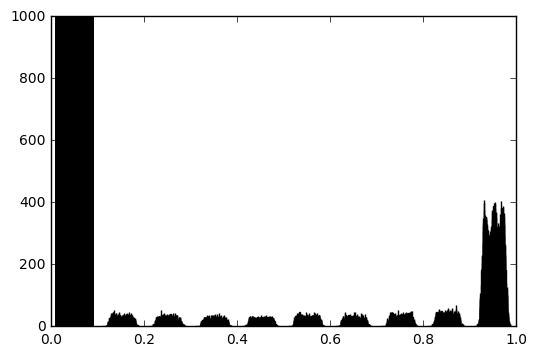

In [11]:
plt.hist(dev_data)
print dev_data.shape[1]

In [12]:
### STUDENT START ###
from sklearn.preprocessing import binarize

# Create new binarized training and test data
binarized_mini_train_data = binarize(mini_train_data,threshold=0.5) #binarize the data using a cutoff of .5
binarized_dev_data = binarize(dev_data,threshold=0.5) # binarize the dev data as well to do the predictions

bins = np.array([0.0, .33, .67, 1.0])
#print mini_train_data    
#the function digitize converts to 0,1,2
multirized_mini_train_data = np.digitize(mini_train_data, bins)-1
multirized_dev_data = np.digitize(dev_data, bins)-1
#print multirized_mini_train_data


def P7():
    bino = BernoulliNB(alpha=.001)
    bino.fit(binarized_mini_train_data, mini_train_labels)

    print 'Binomial accuracy: %3.3f' %bino.score(binarized_dev_data, dev_labels)
    
    multino = MultinomialNB()
    multino.fit(multirized_mini_train_data, mini_train_labels)

    print 'Multinomial accuracy: %3.2f' %multino.score(multirized_dev_data, dev_labels)
    
### STUDENT END ###

P7()

Binomial accuracy: 0.819
Multinomial accuracy: 0.80


ANSWER:  I would expect the Binomial distribution to be better as if you look at the histogram of distribution, you can see that this the values are already pretty binary, with a vast amount of points very low and close to 0 or very high and close to 1.  There are extremely few data points in between, so splitting into 3 in the multinomial distribution gives very few datapoints in the mid.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [15]:
### STUDENT START ###

def P8(alphas):
    
    model = BernoulliNB()
    bino = GridSearchCV(estimator=model, param_grid=alphas)
    bino.fit(binarized_dev_data, dev_labels)
    #print(bino.grid_scores_)
    
    model1 = BernoulliNB(alpha=0)
    model1.fit(binarized_mini_train_data,mini_train_labels)
    print 'alpha:0     accuracy: %3.3f' % model1.score(binarized_dev_data,dev_labels)
    
    #print(bino.best_estimator_)
    return bino

### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)
#print nb


alpha:0     accuracy: 0.099


In [14]:
print nb.best_params_

{'alpha': 0.001}


ANSWER:   The best value for alpha is .001.  If you set alpha=0, this means that if every value you have is 0, your prediction will have 0 probability of being something else.  The score when you set alpha=0 is very poor, at .099.  Yes, this is what I expect.  When using the BernoulliNB, if alpha=0, that means you give very little leeway in terms of assessing very binary numbers where you everything below a certain threshold was already set to 0.  This stringency will create a poor model.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [17]:
### STUDENT END ###
def P9():
    gau = GaussianNB()
    nb = gau.fit(mini_train_data, mini_train_labels)
    dev_pred = gau.predict(dev_data)
    accuracy = np.mean(dev_pred == dev_labels)
    #print nb.sigma_  ## sigma is the variation.
    print accuracy
    
    #theta would be to alter the mean. i chose to alter the variance
    gau.sigma_ += 0.015  #this will alter the variance manually.  we are adding noise to the dataset so that there is nothing with probability 0
    dev_pred = gau.predict(dev_data)
    accuracy = np.mean(dev_pred == dev_labels)
    print accuracy

    
### STUDENT END ###

gnb = P9()

0.621
0.793


ANSWER:  When you look at the sigma value for the fit, you can see that the values are exremely small.  One way to fix this is to add noise to the dataset and create more variance so that there is nothing with probability 0.  To do this, after fitting a model and generating the model sigma value, we manually alter that by setting a different sigma value to create more variance in the dataset.  This allows us to bump our model accuracy.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

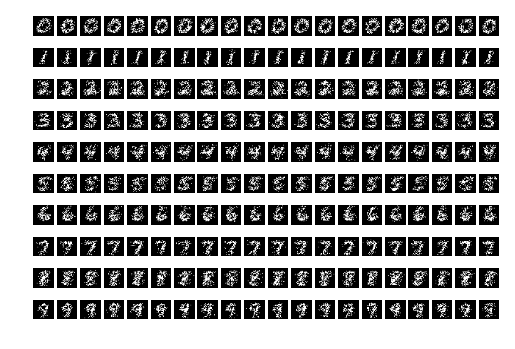

In [18]:
### STUDENT START ###
def P10(num_examples):
    bino = BernoulliNB(alpha=.001)
    bino.fit(binarized_mini_train_data, mini_train_labels)
    
    dev_pred = bino.predict(binarized_dev_data)
    
    for i in xrange(10):
        for j in xrange(num_examples):
            matr = np.exp(bino.feature_log_prob_[i])
            for k,pix in enumerate(matr):
                n = np.random.rand()
                if pix > n:
                    matr[k] = 1
                else:
                    matr[k] = 0
            ax = plt.subplot(10,20,i*20+j+1)
            off = ax.set_axis_off()
            p = plt.imshow(matr.reshape(28,28),cmap=plt.cm.gray, vmin=0.0, vmax=1.0)
### STUDENT END ###

P10(20)

ANSWER:  These generated digits are a lot more uniform accross the examples of each digit, whereas the training set has much more variable figures in the examples.  This is due to the binarization of the model which makes things more clear-cut and consistent as the features becomes more pronounced.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [33]:
### STUDENT START ###
def P11(buckets,correct,total):
    bino = BernoulliNB(alpha=.001)
    bino.fit(binarized_mini_train_data, mini_train_labels)

    dev_pred = bino.predict(binarized_dev_data)
    pred_prob = nb.predict_proba(binarized_dev_data)
    #print pred_prob

    maxpred = []
    maxloc = np.argmax(pred_prob,axis=1)
    for n in range(len(pred_prob)):
        maxpred.append(pred_prob[n][maxloc[n]])
    #print maxpred

    inds = np.digitize(maxpred,buckets)-1
    #print inds

    for n in range(len(inds)):
        #print "%s is in bin %s" % (maxpred[n],inds[n])
        #print "%s was called %s" % (dev_labels[n], dev_pred[n])
        total[inds[n]] += 1
        #print total
        if dev_pred[n] == dev_labels[n]:
            correct[inds[n]] += 1
### STUDENT END ###

buckets = [0,0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
   accuracy = 0.0
   if (total[i] > 0): accuracy = float(correct[i]) / total[i]
   print ' p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

 p(pred) <= 0.0000000000000    total =   2    accuracy = 0.500
 p(pred) <= 0.5000000000000    total =  34    accuracy = 0.265
 p(pred) <= 0.9000000000000    total =  65    accuracy = 0.354
 p(pred) <= 0.9990000000000    total =  52    accuracy = 0.462
 p(pred) <= 0.9999900000000    total =  78    accuracy = 0.692
 p(pred) <= 0.9999999000000    total =  65    accuracy = 0.723
 p(pred) <= 0.9999999990000    total =  65    accuracy = 0.815
 p(pred) <= 0.9999999999900    total =  57    accuracy = 0.895
 p(pred) <= 0.9999999999999    total =  29    accuracy = 0.931
 p(pred) <= 1.0000000000000    total = 553    accuracy = 0.958


ANSWER: I would say that this is a well calibrated model.  As the prediction probability increases, you see increasingly better accuracy.  The only time this is not true is when the prediction probability is under .5, but there are only 2 data points that fit into this bucket anyway.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [95]:
### STUDENT START ###
def P12():
    #print len(mini_train_data)
    #fig, axes = plt.subplots(10, 1)
    for i in range(10): #let's do this for each digit
        digits = mini_train_data[mini_train_labels == i]
        #print mini_train_data[mini_train_labels == i]
        #print len(digits)
        for j, digit in enumerate(digits):
            reshaped = digit.reshape(28, 28) #reshape it so that the data is 28x28
            row_sums = np.sum(reshaped, axis=0).reshape(1,28) #add sum for the rows
            col_sums = np.sum(reshaped, axis=1).reshape(1,28) #add sum for the columns
            new_reshaped = np.concatenate((reshaped,row_sums,col_sums), axis=0)  #now append it to the original data
            new_digit = new_reshaped.reshape(1,840)
            new_list = new_digit.tolist()
        #print new_list
        #print mini_train_data
        
        new_mini_train_data = np.append(mini_train_data, new_list) ##okay, something still buggy here... not sure why
    #now we need to use this new feature when running the data
    #with this new data now we can re-run and see if the extra features will be better
    gau = GaussianNB()
    nb = gau.fit(new_mini_train_data, mini_train_labels)
    dev_pred = gau.predict(dev_data)
    accuracy = np.mean(dev_pred == dev_labels)
    print accuracy
### STUDENT END ###

P12()  #not totally functional, but you give partial extra credit, right?

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


C:\Users\icwang\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Found arrays with inconsistent numbers of samples: [   1 1000]